<a href="https://colab.research.google.com/github/Azorios/DL1/blob/main/modelsave.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install datasets
!pip install tensorboard
!pip install lightning
!pip install pytorch_lightning.metrics
!pip install tensorboard lightning

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.6/474.6 kB 12.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 23.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.3/134.3 kB 15.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.5/212.5 kB 25.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 44.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 268.8/268.8 kB 26.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 149.6/149.6 kB 16.7 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/cola

In [ ]:
import lightning.pytorch as pl
from torchvision import models
from torchvision.models import ResNet50_Weights
import torch.nn as nn
from torch.nn.modules.loss import BCEWithLogitsLoss
import torch
import pickle
from torchmetrics.classification import BinaryAccuracy, BinaryF1Score, BinaryAUROC

class ResNet50(pl.LightningModule):
    def __init__(self, lr=1e-4):
        super().__init__()
        
        # load pretrained model
        self.model = models.resnet50(weights=ResNet50_Weights.DEFAULT)

        # freeze parameters and add customizid final layer for binary classification
        for params in self.model.parameters(): params.requires_grad_ = False
        self.model.fc = nn.Linear(in_features=self.model.fc.in_features, out_features=1)

        self.loss_function = BCEWithLogitsLoss()
        self.lr = lr

        self.acc = BinaryAccuracy()
        self.f1_score = BinaryF1Score()
        self.auroc = BinaryAUROC()

    def forward(self, images):
        return self.model(images)
    
    def configure_optimizers(self):
        return torch.optim.Adam(self.model.fc.parameters(), lr=self.lr)
    
    def training_step(self, batch, batchidx):
        images = batch['pixel_values']
        labels = batch['label'].unsqueeze(-1).float()

        output = self.forward(images)
        predictions = torch.sigmoid(output)

        # compute loss
        loss = self.loss_function(output, labels)

        # calculate accuracy for training
        acc = self.acc(predictions, labels)

        self.log('train_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('train_acc', acc, on_epoch=True)

        return loss
    
    def on_train_epoch_end(self, outputs):
        loss = sum(output['train_loss'] for output in outputs) / len(outputs)
        print(loss)
    
    def validation_step(self, batch, batchidx):
        #images, labels = batch
        images = batch['pixel_values']
        labels = batch['label'].unsqueeze(-1).float()

        output = self.forward(images)
        predictions = torch.sigmoid(output)

        # compute loss
        loss = self.loss_function(output, labels)

        # calculate accuracy for training
        acc = self.acc(predictions, labels)
        print('validation_step loss: ', loss)
        self.log('val_loss', loss, on_epoch=True, prog_bar=True, logger=True)
        self.log('val_acc', acc, on_epoch=True)

        return loss

    def on_validation_epoch_end(self, outputs):
        loss = sum(output['val_loss'] for output in outputs) / len(outputs)
        print('on_validation_epoch_end: ', loss)

    def test_step(self, batch, batchidx):
        images = batch['pixel_values']
        labels = batch['label'].unsqueeze(-1).float()

        output = self.forward(images)
        predictions = torch.sigmoid(output)

        # calculate accuracy for training
        acc = self.acc(predictions, labels)
        f1_score = self.f1_score(predictions, labels)
        auroc= self.auroc(predictions, labels)

        self.log('test_acc', acc, on_epoch=True)
        self.log('f1_score', f1_score)
        self.log('auroc', auroc)
        

In [ ]:
!pip install transformers


import torch
import torch.nn as nn
from PIL import Image
from torch.utils.data import DataLoader, TensorDataset
from torch.nn.modules.loss import BCEWithLogitsLoss
from torchvision import models, datasets
from torchvision.transforms import Normalize, Compose, RandomResizedCrop, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Resize, CenterCrop
from torchvision.models import ResNet50_Weights
from datasets import load_dataset, concatenate_datasets
from transformers import AutoImageProcessor
import matplotlib.pyplot as plt
import numpy as np
import lightning.pytorch as pl
from pytorch_lightning.callbacks import ModelCheckpoint

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 43.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 40.1 MB/s eta 0:00:00


In [ ]:
# used device for computing
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device, 'will be used.')

# datasets
fake = load_dataset('poloclub/diffusiondb', '2m_random_10k', split='train', data_dir='./')
real = load_dataset('frgfm/imagenette', '320px', split='train+validation', data_dir='./')

# remove unnecessary comlumns
fake = fake.remove_columns(['prompt', 'seed', 'step', 'cfg', 'sampler', 'width', 'height', 'user_name', 'timestamp', 'image_nsfw', 'prompt_nsfw'])
real = real.remove_columns('label')

# add label column
fake = fake.map(lambda x: {'image': x['image'], 'label':1})
real = real.map(lambda x: {'image': x['image'], 'label':0})

# split fake dataset into train, validation and test sets
fake_train_testvalid = fake.train_test_split(test_size=0.2)
fake_test_valid = fake_train_testvalid['test'].train_test_split(test_size=0.5)

# split real dataset into train, validation and test sets
real_train_testvalid = real.train_test_split(test_size=0.2)
real_test_valid= real_train_testvalid['test'].train_test_split(test_size=0.5)

# combine fake and real datasets into single dataset for each split
train_dataset = concatenate_datasets([fake_train_testvalid['train'], real_train_testvalid['train']])
val_dataset = concatenate_datasets([fake_test_valid['train'], real_test_valid['train']])
test_dataset = concatenate_datasets([fake_test_valid['test'], real_test_valid['test']])

cpu will be used.


Generating train split: 0 examples [00:00, ? examples/s]

Dataset diffusiondb downloaded and prepared to /root/.cache/huggingface/datasets/poloclub___diffusiondb/2m_random_10k-data_dir=.%2F/0.9.1/547894e3a57aa647ead68c9faf148324098f47f2bc1ab6705d670721de9d89d1. Subsequent calls will reuse this data.


Generating train split:   0%|          | 0/9469 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3925 [00:00<?, ? examples/s]

Dataset imagenette downloaded and prepared to /root/.cache/huggingface/datasets/frgfm___imagenette/320px-data_dir=.%2F/1.0.0/38929285b8abcae5c1305418e9d8fea5dd6b189bbbd22caba5f5537c7fa0f01f. Subsequent calls will reuse this data.


Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/13394 [00:00<?, ? examples/s]

In [ ]:
print(train_dataset)
# transform/preprocess input
train_transforms = Compose([
    RandomResizedCrop(224),
    RandomHorizontalFlip(),
    RandomVerticalFlip(),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

val_transforms = Compose([
    Resize(256),
    CenterCrop(224),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

test_transforms = Compose([
    Resize(224),
    ToTensor(),
    Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ])

def transform_train(batch):
    batch['pixel_values'] = [train_transforms(img.convert("RGB")) for img in batch['image']]
    del batch['image']
    return batch

def transform_val(batch):
    batch['pixel_values'] = [val_transforms(img.convert("RGB")) for img in batch['image']]
    del batch['image']
    return batch

def transform_test(batch):
    batch['pixel_values'] = [test_transforms(img.convert("RGB")) for img in batch['image']]
    del batch['image']
    return batch

# apply transforms and preprocessing
train_dataset.set_transform(transform_train)
val_dataset.set_transform(transform_val)
test_dataset.set_transform(transform_test)

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=0)


Dataset({
    features: ['image', 'label'],
    num_rows: 18715
})


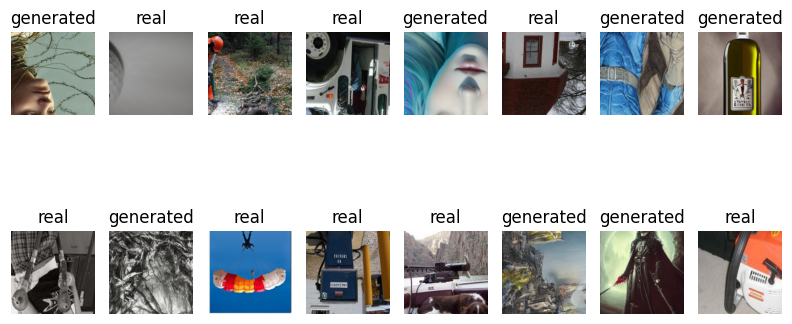

In [ ]:
# show example image
def inv_trans(image):
    '''
    Inverse transformations so that colors are in normal range.
    '''
    inverse_trans = Compose([
        Normalize(mean = [0., 0., 0.], std= [1/0.229, 1/0.224, 1/0.225]), 
        Normalize(mean=[-0.485, -0.456, -0.406], std = [1., 1., 1.])])
    
    return inverse_trans(image)


def imshow(images, labels, batch_size):
    ''' 
    Display images (batch) in one figure with labels. 
    '''
    fig = plt.figure(figsize=(8, 5))
    rows, columns = 2, 8

    for i in range(batch_size):
        unnorm_im = inv_trans(images[i]).cpu().numpy()
        if int(labels[i]) == 0: label = 'real'
        else: label = 'generated'

        fig.add_subplot(rows, columns, i+1)
        plt.imshow(np.transpose(unnorm_im, (1, 2, 0)))
        plt.axis('off')
        plt.title(label)

    fig.tight_layout()
    plt.show()

# showcase some training images
data = next(iter(train_loader))
images = data['pixel_values'].to(device)
labels = data['label'].to(device)
imshow(images, labels, batch_size)

In [10]:
# load pretrained resnet50 model from PyTorch
checkpoint_callback = ModelCheckpoint(
    monitor='val_loss',
    save_top_k=1,

    every_n_epochs=1)

model = ResNet50()#.load_from_checkpoint(checkpoint_callback.best_model_path)
#print(model)

try:
    load_model = torch.jit.load('./models/resnet50_ds1.pth')
    with torch.no_grad():
        print(load_model)
    # model.load_state_dict(torch.load('./models/resnet50.pth'))
    # model.name = 'resnet50'
except ValueError:
    pass

trainer = pl.Trainer(max_epochs=1, callbacks=[checkpoint_callback])

trainer.fit(model, train_loader, val_loader)
trainer.test(model, test_loader)
model.eval()
with torch.no_grad():
    traced = torch.jit.trace(model, torch.rand(1, 3, 224, 224))
torch.jit.save(traced, './models/resnet50_ds1.pth')

reloaded = torch.jit.load('./models/resnet50_ds1.pth')
with torch.no_grad():
    print(reloaded)

ValueError: ignored